In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math as math

from PIL import Image

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# read in our processed dataset of spectrograms and popularity classes

processed_dataset = pd.read_csv('processed_dataset.csv')  
processed_dataset = processed_dataset.values
print(processed_dataset.shape)
image_list = []
#build matrix of spectrograms
for item in processed_dataset:
    #read in image, convert to matrix of pixels, chop off alpha values, convert to gray-scale
    image_file = item[3]
    image = imageio.imread(image_file)
    image = np.dot(image[...,:4], [0.299, 0.587, 0.114, 0])
    image_list.append(image)
print(len(image_list))
image_data = np.stack(image_list, axis=0)
print(image_data.shape)

labels_data = processed_dataset[:, 2]

(1051, 4)
1051
(1051, 102, 159)


In [3]:
# Create train, dev, and test sets (the data is already randomized)
train_data = image_data[0:851]
dev_data = image_data[851:951]
test_data = image_data[951:1051]

train_labels = labels_data[0:851]
dev_labels = labels_data[851:951]
test_labels = labels_data[951:1051]

train_labels = np.eye(3)[train_labels.astype(int)]
dev_labels = np.eye(3)[dev_labels.astype(int)]
test_labels = np.eye(3)[test_labels.astype(int)]

print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(dev_labels.shape)
print(test_labels.shape)

(851, 102, 159)
(100, 102, 159)
(100, 102, 159)
(851, 3)
(100, 3)
(100, 3)


In [4]:
# compute distribution of train data

num_low_pop = 0
num_med_pop = 0
num_high_pop = 0
for item in train_labels:
    if item[0] == 1:
        num_low_pop += 1
    elif item[1] == 1:
        num_med_pop += 1
    else:
        num_high_pop += 1
    
percent_train_low = float(num_low_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_train_med = float(num_med_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_train_high = float(num_high_pop)/(num_low_pop + num_med_pop + num_high_pop)

print('percent of training data that is low population:', percent_train_low)
print('percent of training data that is med population:', percent_train_med)
print('percent of training data that is high population:', percent_train_high)

percent of training data that is low population: 0.16216216216216217
percent of training data that is med population: 0.46650998824911866
percent of training data that is high population: 0.37132784958871917


In [5]:
# compute distribution of dev data

num_low_pop = 0
num_med_pop = 0
num_high_pop = 0
for item in dev_labels:
    if item[0] == 1:
        num_low_pop += 1
    elif item[1] == 1:
        num_med_pop += 1
    else:
        num_high_pop += 1
    
percent_dev_low = float(num_low_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_dev_med = float(num_med_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_dev_high = float(num_high_pop)/(num_low_pop + num_med_pop + num_high_pop)

print('percent of dev data that is low population:', percent_dev_low)
print('percent of dev data that is med population:', percent_dev_med)
print('percent of dev data that is high population:', percent_dev_high)

percent of dev data that is low population: 0.24
percent of dev data that is med population: 0.48
percent of dev data that is high population: 0.28


In [6]:
# compute distribution of test data

num_low_pop = 0
num_med_pop = 0
num_high_pop = 0
for item in test_labels:
    if item[0] == 1:
        num_low_pop += 1
    elif item[1] == 1:
        num_med_pop += 1
    else:
        num_high_pop += 1
    
percent_test_low = float(num_low_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_test_med = float(num_med_pop)/(num_low_pop + num_med_pop + num_high_pop)
percent_test_high = float(num_high_pop)/(num_low_pop + num_med_pop + num_high_pop)

print('percent of test data that is low population:', percent_test_low)
print('percent of test data that is med population:', percent_test_med)
print('percent of test data that is high population:', percent_test_high)

percent of test data that is low population: 0.24
percent of test data that is med population: 0.46
percent of test data that is high population: 0.3


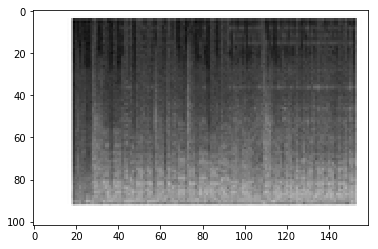

In [9]:
#1 example gray-scaled image
plt.imshow(train_data[0], cmap='gray')

In [14]:
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
dev_data = np.reshape(dev_data, (dev_data.shape[0], dev_data.shape[1], dev_data.shape[2], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1],test_data.shape[2], 1))

In [15]:
# create tf tensors for model
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    # x will contain train examples
    features = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0], name='x')
    # labels will contain the true popularity scores
    labels = tf.placeholder(tf.float32, shape=[None, n_y], name='y_true')
    return features, labels

In [16]:
X, Y = create_placeholders(train_data.shape[1], train_data.shape[2], 1, 3)
print ("X =" + str(X))
print ("Y =" + str(Y))

X =Tensor("x:0", shape=(?, 102, 159, 1), dtype=float32)
Y =Tensor("y_true:0", shape=(?, 3), dtype=float32)


In [17]:
# filter size = f, f, previous num filters, num filters
# channels = 1
f1 = 3
f2 = 2
channels = 1
num_filters = 4
def initialize_parameters(f1, f2, channels, num_filters):
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [f1,f1,channels,num_filters], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [f2,f2,num_filters,num_filters*2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1":W1,
                  "W2":W2}
    
    return parameters

In [18]:
def forward_propogation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # first convolutional layer:     strides = 1 ... [1,s,s,1]
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding='SAME')
    # relu activation
    A1 = tf.nn.relu(Z1)
    # maxpool:     strides = 4... [1,s,s,1], window = 4x4...[1,f,f,1]
    P1 = tf.nn.max_pool(A1, ksize=[1,4,4,1], strides = [1,4,4,1], padding='SAME')
    
    # second convolutional layers:     strides = 1 ... [1,s,s,1]
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding='SAME')
    # relu activation
    A2 = tf.nn.relu(Z2)
    # maxpool:     strides = 4... [1,s,s,1], window = 4x4...[1,f,f,1]
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    
    #Flatten
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 3, activation_fn=None)
    
    return Z3

In [19]:
# test 1 instance of the network
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(train_data.shape[1], train_data.shape[2], 1, 3)
    parameters = initialize_parameters(3, 2, 1, 4)
    Z3 = forward_propogation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: train_data[0:2], Y: train_labels[0:2]})
    print("Z3 = " + str(a))

Instructions for updating:
Use the retry module or similar alternatives.
Z3 = [[-11.269575   16.101578    7.013256 ]
 [-10.14007    12.445746    7.7696457]]


In [20]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [21]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
	m = X.shape[0]
	mini_batches = []
	np.random.seed(seed)

	# Step 1:
	permutation = list(np.random.permutation(m))
	shuffled_X = X[permutation,:,:,:]
	shuffled_Y = Y[permutation,:]

	# Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
	num_complete_minibatches = math.floor(m/mini_batch_size)
	for k in range(0, num_complete_minibatches):
		mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
		mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
		mini_batch = (mini_batch_X, mini_batch_Y)
		mini_batches.append(mini_batch)
	# Handling the end case (last mini-batch < mini_batch_size)
	if m % mini_batch_size != 0:
		mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
		mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
		mini_batch = (mini_batch_X, mini_batch_Y)
		mini_batches.append(mini_batch)
	return mini_batches

In [22]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 1, print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters(3, 2, n_C0, 4)
    Z3 = forward_propogation(X, parameters)
    
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        # plot the cost 
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y,1))
            
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})

        print("Train Accuracy", train_accuracy)
        print("Test Accuracy", test_accuracy)
            
        return train_accuracy, test_accuracy, parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0: 3.118529
Cost after epoch 5: 1.783449
Cost after epoch 10: 1.413339
Cost after epoch 15: 1.227608
Cost after epoch 20: 1.132312
Cost after epoch 25: 1.066303
Cost after epoch 30: 1.005326
Cost after epoch 35: 0.972094
Cost after epoch 40: 0.933389
Cost after epoch 45: 0.920747
Cost after epoch 50: 0.901358
Cost after epoch 55: 0.882170
Cost after epoch 60: 0.865513
Cost after epoch 65: 0.858104
Cost after epoch 70: 0.854403
Cost after epoch 75: 0.827852
Cost after epoch 80: 0.822584
Cost after epoch 85: 0.810754
Cost after epoch 90: 0.809172
Cost after epoch 95: 0.787959


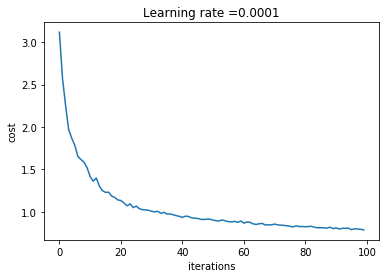

Parameters have been trained!
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy 0.63689774
Test Accuracy 0.41


In [23]:
# Test with dev set
_, _, parameters = model(train_data, train_labels, dev_data, dev_labels)

In [ ]:
# current distributions of train and dev set (low, med, high): 
# train = (16.21%, 46.651%, 37.13%)
# dev = (24%, 48%, 28%)

# NOTE: We need more data before we can really determine what strategies to use (e.g. deeper network, regularization, etc.)


# learning_rate = .00005, epochs = 200, minibatch_size = 3: train = 60.5%, test = 44%
# learning_rate = .00005, epochs = 100, minibatch_size = 3: train = 51.47%, test = 45%
# learning_rate = .0001, epochs = 100, minibatch_size = 3: train = 59.34%, test = 43%
# learning_rate = .0001, epochs = 100, minibatch_size = 5: train = 53.7%, test = 35%
# learning_rate = .0001, epochs = 100, minibatch_size = 1: train = 63.69, test = 41%
# learning_rate = .005, epochs = 100, minibatch_size = 3: train = 46.651% , test = 47%
